In [4]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from keras import models, layers
from keras import losses, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model
from pathlib import Path
from skimage.morphology import label
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

data_folder = Path('/home/yuyuliao/ninja_project/data/airbus/')

os.listdir(str(data_folder))

Using TensorFlow backend.


_pywrap_tensorflow_internal /usr/local/lib/python3.5/dist-packages/tensorflow/python/_pywrap_tensorflow_internal.so


['train_ship_segmentations_v2.csv',
 'sample_submission_v2.csv',
 'test_v2.zip',
 'train',
 'train_v2.zip',
 'train_ship_segmentations_v2.csv.zip',
 'test']

In [5]:
BATCH_SIZE = 5
EDGE_CROP = 16
NB_EPOCHS = 10
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# Downsampling inside the network
NET_SCALING = None

# Downsampling in preprocessing
IMG_SCALING = (1, 1)

# Number of validation images to use
VALID_IMG_COUNT = 400

# Maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [6]:
masks = pd.read_csv(str(data_folder / 'train_ship_segmentations_v2.csv'))
train_path = data_folder / 'train'
valid_path = data_folder / 'test'
test_path = data_folder / 'test'
train_images_list = os.listdir(str(train_path))
test_images_list = os.listdir(str(test_path))

# Show data

No ships percentage:0.22101 
Ships percentage:0.77899


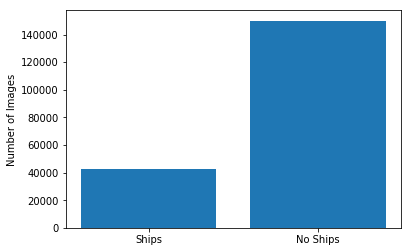

In [4]:
masks.head()

ships = masks[~masks.EncodedPixels.isna()].ImageId.unique()
noships = masks[masks.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

num_duplicate_image = len(ships) + len(noships)
print('No ships percentage:{:.5f} \nShips percentage:{:.5f}'.format(len(ships) / num_duplicate_image,
                                                                    len(noships) / num_duplicate_image))

In [5]:
(len(noships) + len(ships))

192556

In [6]:
print('Total raw data:{}'.format(masks.shape[0]))
print('Duplicate images:{}'.format(masks['ImageId'].value_counts().shape[0]))

Total raw data:231723
Duplicate images:192556


In [25]:
# multi-ships images
masks[masks['ImageId'] == '11f3bae66.jpg']

ImageId                                      EncodedPixels  ships
16324  11f3bae66.jpg       7945 7 8713 7 9481 7 10250 7 11018 7 11786 3      1
16325  11f3bae66.jpg  389679 2 390447 6 391214 10 391982 12 392750 1...      1
16326  11f3bae66.jpg  246730 3 247498 8 248266 13 249033 16 249801 1...      1
16327  11f3bae66.jpg  19440 9 20208 17 20976 17 21744 17 22512 17 23...      1
16328  11f3bae66.jpg  23297 6 24065 11 24833 11 25601 11 26369 11 27...      1
16329  11f3bae66.jpg  394297 1 395065 5 395833 7 396600 8 397368 8 3...      1
16330  11f3bae66.jpg  24077 10 24845 21 25613 21 26381 21 27149 21 2...      1
16331  11f3bae66.jpg  248281 3 249050 7 249818 11 250586 14 251353 1...      1
16332  11f3bae66.jpg  38634 3 39402 5 40170 5 40937 6 41705 6 42473 ...      1
16333  11f3bae66.jpg  252151 4 252918 10 253686 10 254454 10 255222 ...      1
16334  11f3bae66.jpg  62855 2 63621 4 64386 8 65152 10 65918 12 6668...      1
16335  11f3bae66.jpg  381222 2 381990 6 382758 9 383525 12 384293 12...      1
16336  11f3bae66.jpg  249065 4 249833 10 250601 14 251368 15 252136 ...      1
16337  11f3bae66.jpg  398145 2 398913 4 399680 7 400448 8 401215 9 4...      1
16338  11f3bae66.jpg  385052 3 385820 7 386588 8 387355 9 388123 9 3...      1

# Split into training and validation groups

In [23]:
masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

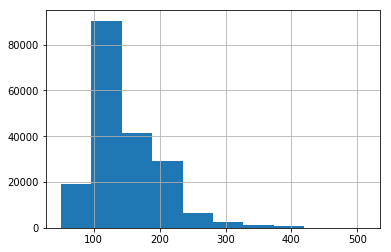

In [79]:
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda img_id: os.stat(str(train_path / img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50 ] # keep only greater 50 kb files
unique_img_ids['file_size_kb'].hist()



In [81]:
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

ImageId  ships  has_ship has_ship_vec  file_size_kb
119519  9efcf00a0.jpg      0       0.0        [0.0]    246.068359
152404  cab2879ae.jpg      0       0.0        [0.0]    122.746094
3281    046a4c92b.jpg      0       0.0        [0.0]    108.708984
81695   6c8068f9e.jpg      0       0.0        [0.0]    132.350586
165645  dc67cd274.jpg      0       0.0        [0.0]    112.345703

In [83]:
train_ids, valid_ids = train_test_split(unique_img_ids, test_size=0.3, 
                                        stratify=unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print('Train images:{}'.format(train_df.shape[0]))
print('Valid images:{}'.format(valid_df.shape[0]))

Train images:161048
Valid images:69034


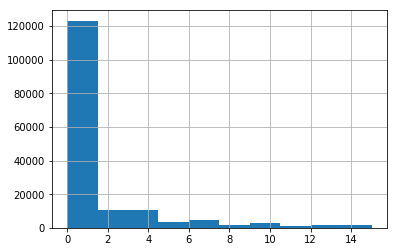

In [84]:
# 船隻個數的分佈/images
train_df['ships'].hist()

# Undersample Empty Images

Here we undersample the empty images to get a better balanced group with more ships to try and segment

In [102]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 7)

def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val // 3)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0] < base_rep_val))

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)

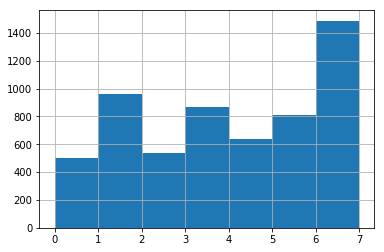

In [115]:
balanced_train_df['ships'].hist(bins=np.arange(8))

# Show images

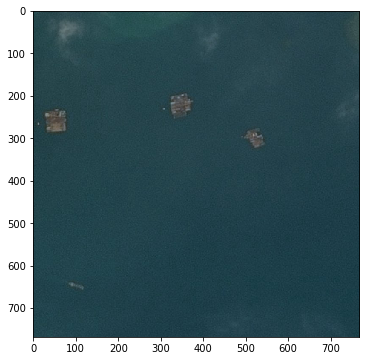

In [59]:
plt.figure(figsize=(8, 6))
check_img = plt.imread(str(train_path / '11f3bae66.jpg'))
plt.imshow(check_img)


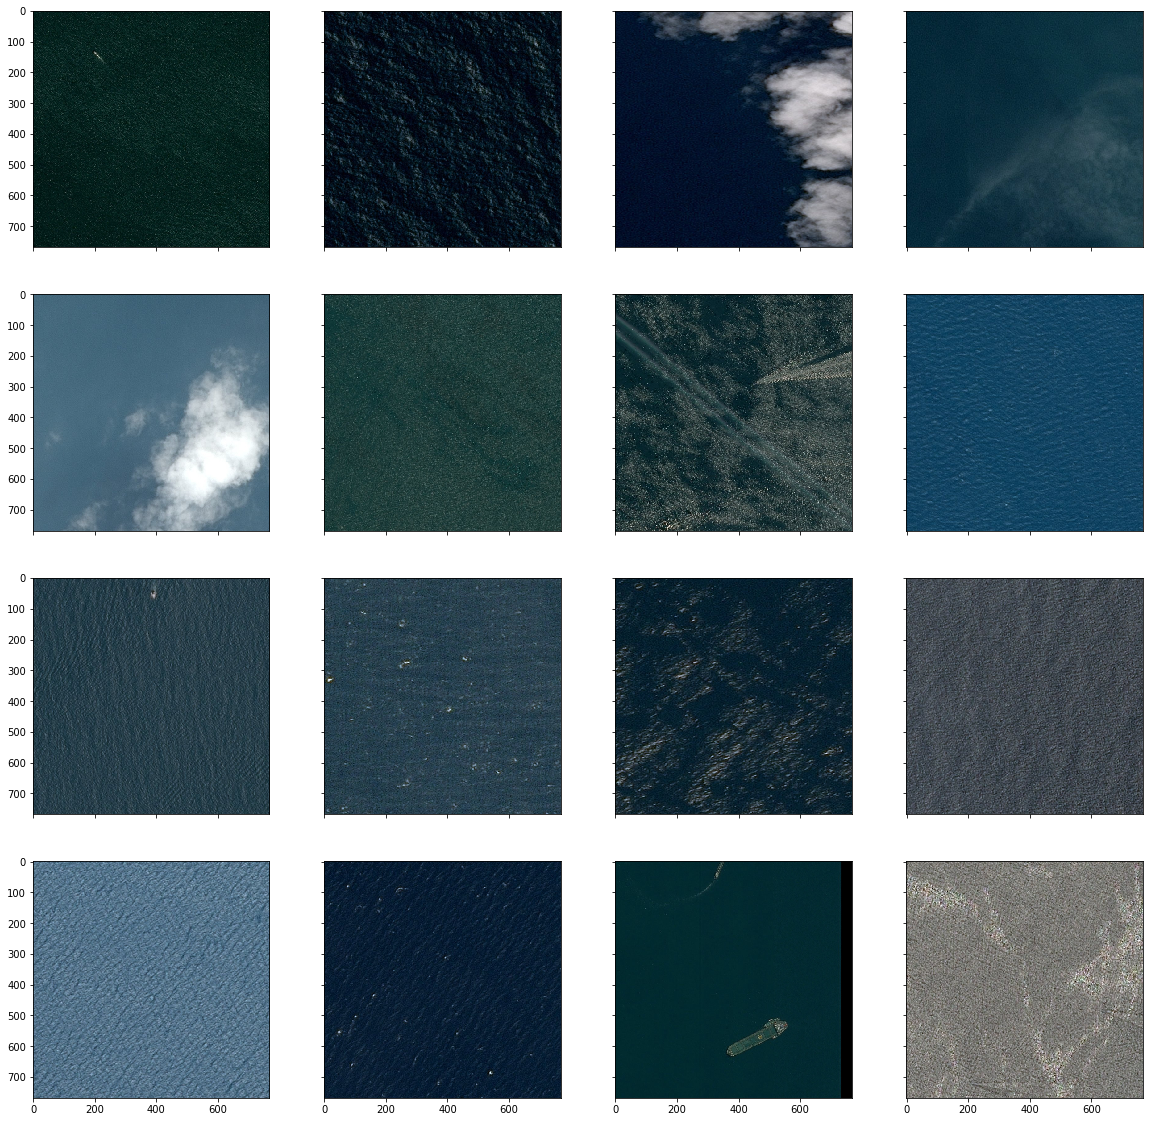

In [61]:
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)
for i, imgid in enumerate(images[0:16]):
    col = i % 4
    row = i // 4
    path = data_folder / 'train' / imgid
    img = plt.imread(path)
    ax[row, col].imshow(img)    
#image = plt.imread(str(data_folder / 'train' / images[0]))
#plt.title(images[0])
#plt.imshow(image), image.shape

# Remove bug image
Image data cannot be converted to float

In [35]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

# Run-length Encode and Decode

In [74]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_deconde(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x , dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [133]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels > 0])]

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype=np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_deconde(mask)
    return np.expand_dims(all_masks, -1) # 在最後面延伸一個維度


In [75]:
test_img_tasks = masks[masks['ImageId'] == test_img]['EncodedPixels'].tolist()
ImgShape = (768, 768)
all_mask = np.zeros(ImgShape)
for mask in test_img_tasks:
    # NaN should compare as not equal to itself
    if mask == mask:
        all_mask += rle_deconde(mask, ImgShape)


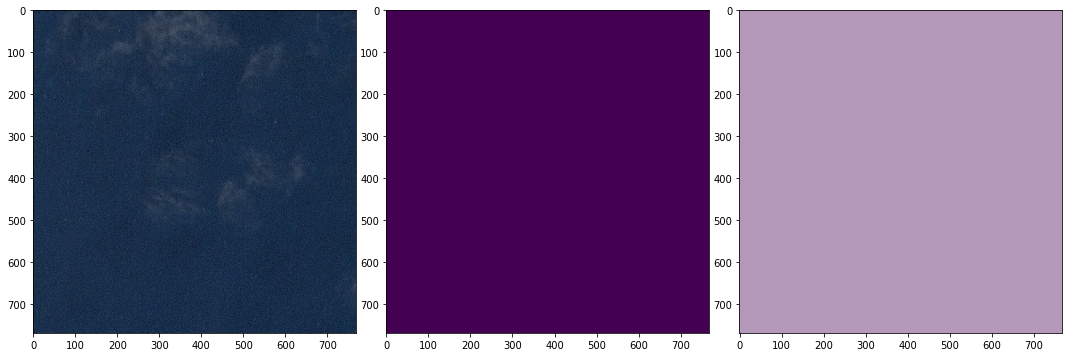

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(15, 40))
ax[0].imshow(tt)
ax[1].imshow(all_mask)
ax[2].imshow(all_mask, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


## Make sure encode/decode works

Text(0.5,1,'Image$_1$')

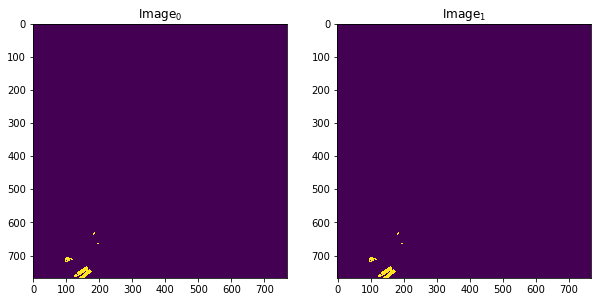

In [78]:
### RLE --> decode image --> encode to RLE --> decode image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rle_0 = masks.query('ImageId == "00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')


# Decode all the RLEs into images


In [165]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batchs = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batchs)
        for c_img_id, c_masks in all_batchs:
            rgb_path = str(train_path / c_img_id)
            c_img = io.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values) 
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0) / 255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []
            

In [166]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def m

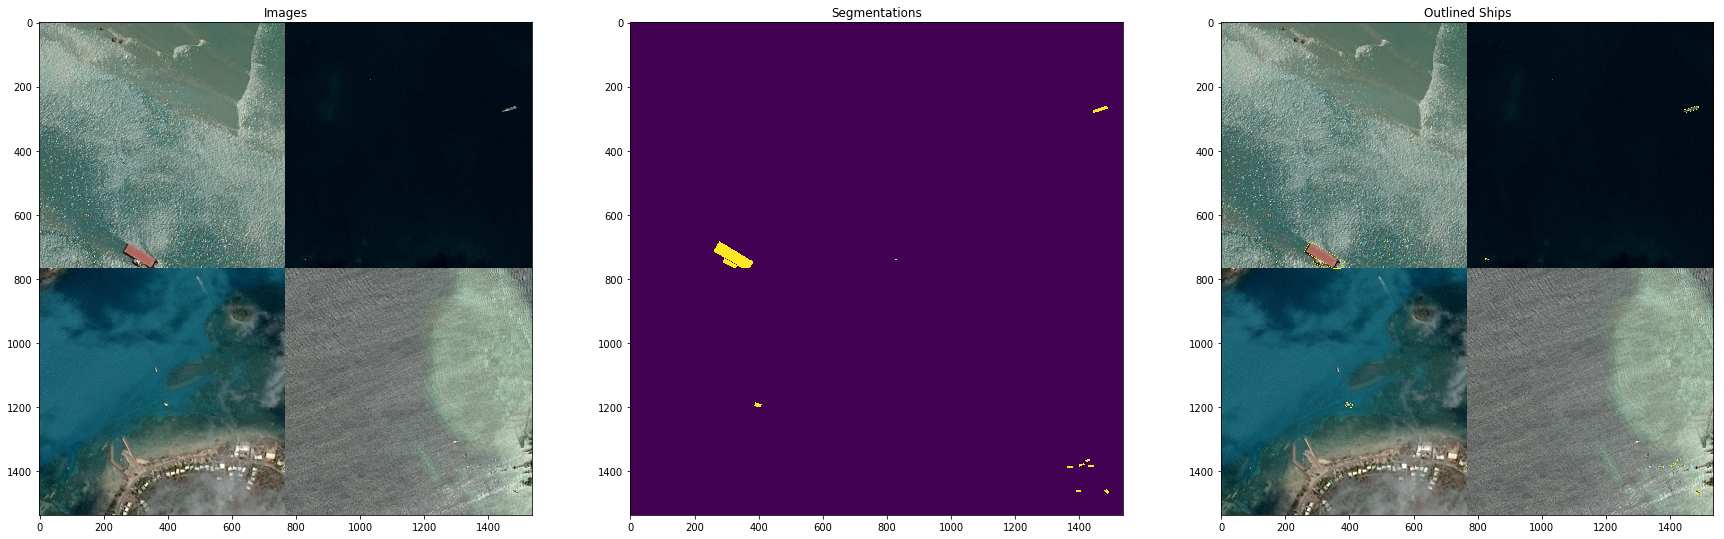

In [183]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Make the Validation Set

In [184]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


# Data Augment

In [195]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    data_format='channels_last'
    )

# brightness can be problematic since it seems to change 
# the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
    
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed=202109):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255 * in_x, 
                             batch_size=in_x.shape[0],
                             seed=seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size=in_y.shape[0],
                             seed=seed,
                             shuffle=True)
        yield next(g_x) / 255.0, next(g_y)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.5/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def m

Text(0.5,1,'ships')

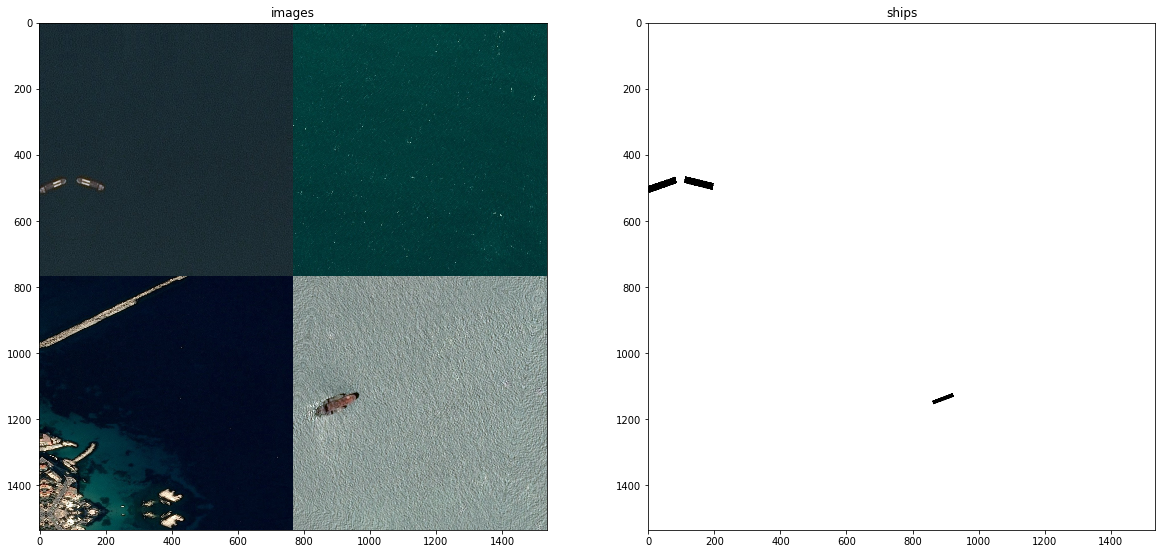

In [211]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#t_x = t_x[:9]
#t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [213]:
import gc
gc.collect()

115812

# Build U-Net Model

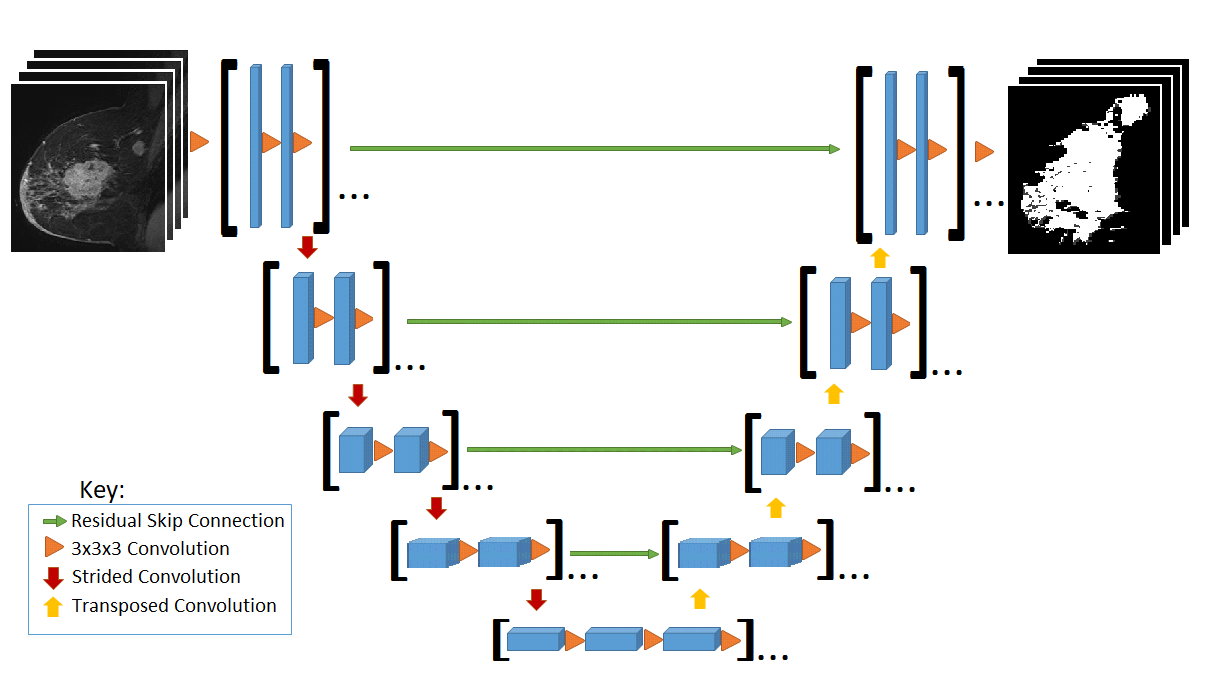

In [225]:
# https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
from IPython.display import Image
Image(filename='u-net.png') 

In [256]:
from keras.layers import GaussianNoise, BatchNormalization
from keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D

def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)   
    
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
# c4 = Dropout(0.2)(c4)
p4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
# c5 = Dropout(0.3)(c5)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_12 (GaussianNois (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 768, 768, 3)  12          gaussian_noise_12[0][0]          
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 768, 768, 8)  224         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_176

# Define loss function

In [261]:
def dic_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3 * losses.binary_crossentropy(in_gt, in_pred) - dic_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred)))/K.sum(y_true)



In [ ]:
isMultiGPU = 1
if isMultiGPU:
    parallel_model = multi_gpu_model(seg_model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), loss=dice_p_bce,
                           metrics=[dic_coef, 'binary_accuracy', true_positive_rate])
else:
    seg_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), loss=dice_p_bce,
                      metrics=[dic_coef, 'binary_accuracy', true_positive_rate])
                  

In [264]:
weight_path = "{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', 
                            verbose=1, save_best_only=True, mode='max',
                            save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, verbose=1, mode='max', epsilon=0.0001,
                                   cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor='val_dice_coef', mode='max', patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [277]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0] // BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

if isMultiGPU:
    loss_history = [parallel_model.fit_generator(aug_gen, 
                                                 steps_per_epoch=step_count,
                                                 epochs=NB_EPOCHS,
                                                 validation_data=(valid_x, valid_y),
                                                 callbacks=callbacks_list,
                                                 use_multiprocessing=False,
                                                 workers=1)]    
else:
    loss_history = [seg_model.fit_generator(aug_gen, 
                                            steps_per_epoch=step_count,
                                            epochs=NB_EPOCHS,
                                            validation_data=(valid_x, valid_y),
                                            callbacks=callbacks_list,
                                            use_multiprocessing=False,
                                            workers=1)]

Epoch 1/5
200/200 [==============================] - 202s 1s/step - loss: -0.0341 - dic_coef: 0.0347 - binary_accuracy: 0.6149 - true_positive_rate: 0.5252 - val_loss: -0.7163 - val_dic_coef: 0.7163 - val_binary_accuracy: 0.9989 - val_true_positive_rate: nan
Epoch 2/5
200/200 [==============================] - 183s 917ms/step - loss: -0.1081 - dic_coef: 0.1082 - binary_accuracy: 0.9965 - true_positive_rate: 0.0000e+00 - val_loss: -0.7195 - val_dic_coef: 0.7196 - val_binary_accuracy: 0.9989 - val_true_positive_rate: nan
Epoch 3/5
200/200 [==============================] - 187s 933ms/step - loss: -0.1502 - dic_coef: 0.1503 - binary_accuracy: 0.9967 - true_positive_rate: 0.0000e+00 - val_loss: -0.7258 - val_dic_coef: 0.7258 - val_binary_accuracy: 0.9989 - val_true_positive_rate: nan
Epoch 4/5
200/200 [==============================] - 186s 932ms/step - loss: -0.1393 - dic_coef: 0.1393 - binary_accuracy: 0.9967 - true_positive_rate: 0.0000e+00 - val_loss: -0.7211 - val_dic_coef: 0.7211 - v

Text(0.5,1,'DICE')

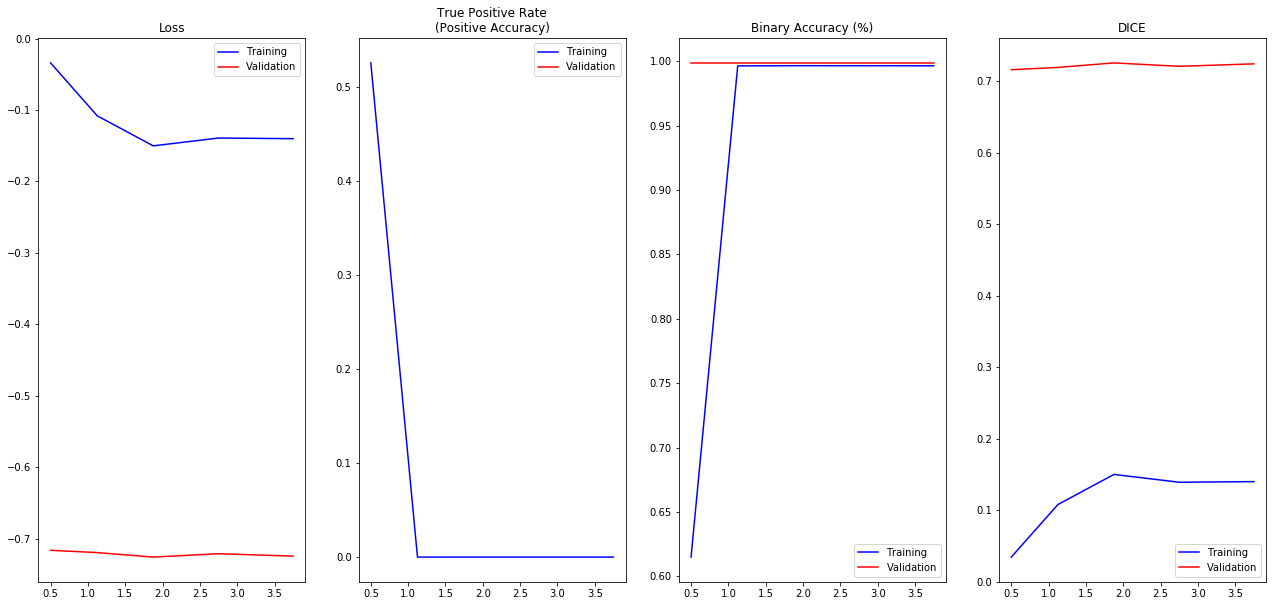

In [301]:
epich = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 
             'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate([mh.history['true_positive_rate'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_true_positive_rate'] for mh in loss_history]),
             'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('True Positive Rate\n(Positive Accuracy)')

_ = ax3.plot(epich, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]),
             'b-', epich, 
             np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]),
             'r-')
ax3.legend(['Training', 'Validation'])
ax3.set_title('Binary Accuracy (%)')
    
_ = ax4.plot(epich, np.concatenate([mh.history['dic_coef'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dic_coef'] for mh in loss_history]),
             'r-')
ax4.legend(['Training', 'Validation'])
ax4.set_title('DICE')


In [303]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(400, 768, 768, 1) 0.0 0.011416089 4.0644018e-06


In [1]:
fig, ax = plt.subplots(1, 1, figsize = (8, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

NameError: name 'plt' is not defined

# Run the test data

In [318]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
#fullres_model.save('fullres_model.h5')

In [327]:
print(len(test_images_list), 'test images found')

15606 test images found


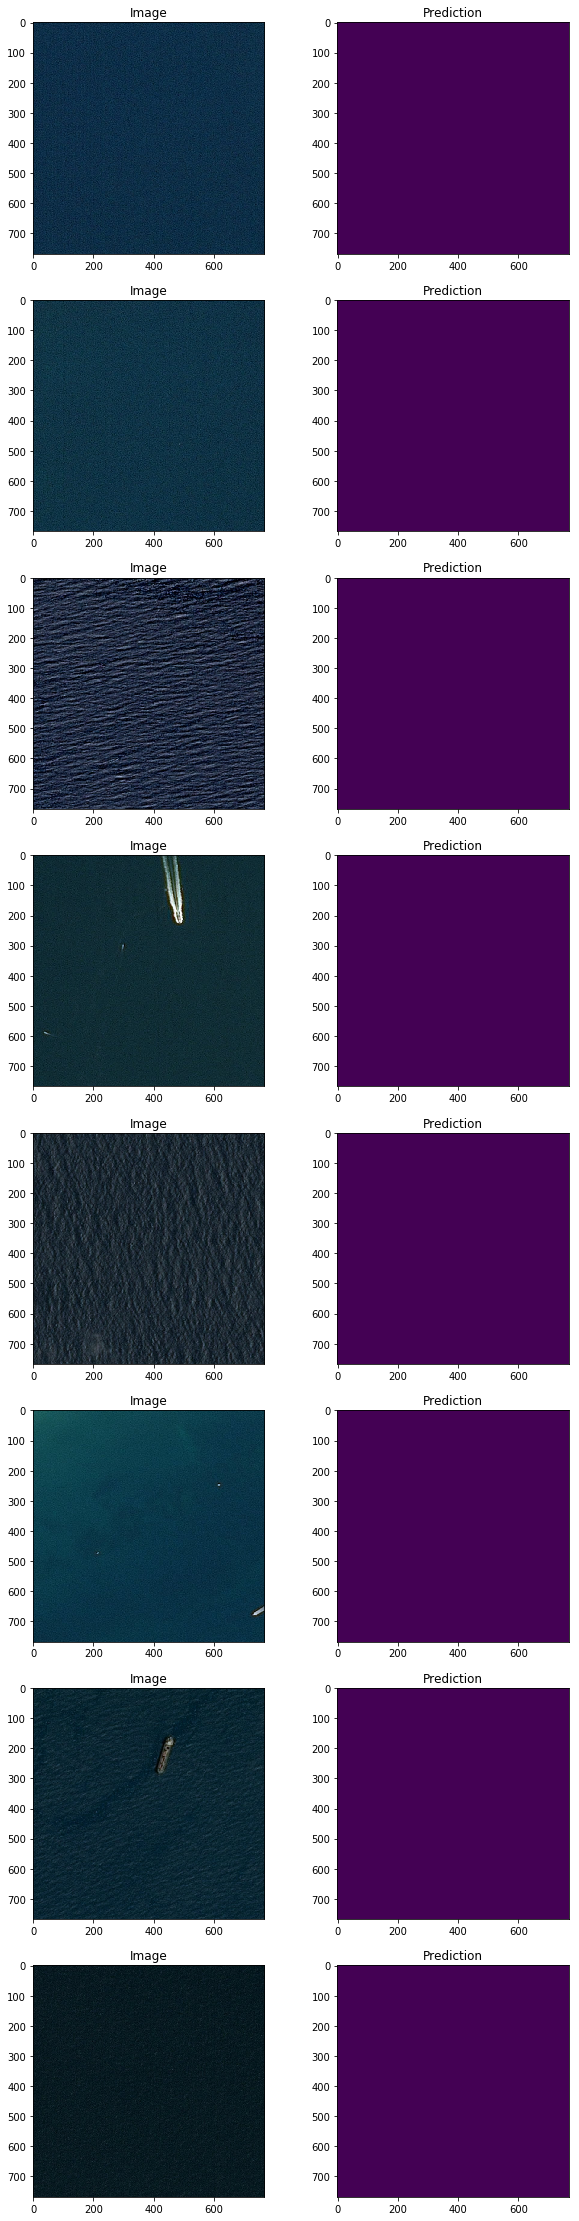

In [324]:
fig, m_axs = plt.subplots(8, 2, figsize = (10, 40))
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(str(test_path), c_img_name)
    c_img = io.imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

# Create Submission

In [346]:
%%time
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in test_images_list:
    c_path = str(test_path / c_img_name)
    c_img = io.imread(c_path)
    c_img = np.expand_dims(c_img, 0) / 255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg > 0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles) > 0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()


CPU times: user 2h 15min 43s, sys: 1min 41s, total: 2h 17min 24s
Wall time: 2h 40min 24s


In [347]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
sub_file_name = 'submission_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M%S'))
submission_df.to_csv(sub_file_name, index=False)
submission_df.sample(3)

ImageId EncodedPixels
6229   41a197bae.jpg          None
13520  6b4ceeabd.jpg          None
14791  c0550d6f7.jpg          None

In [70]:
def mask_part(pic):
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1 + int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    df = marks[marks['ImageId'] == key].iloc[:, 1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False

def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768, 768, 1))
    if is_empty(key):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1, 0, 2))    

In [30]:
def transform(X, Y):
    x = np.copy(X)
    y = np.copy(Y)
    # add noise
    x[:, :, 0] = x[:, :, 0] + np.randomn.normal(loc=0.0, scale=0.01, size=(768, 768))
    x[:, :, 1] = x[:, :, 1] + np.randomn.normal(loc=0.0, scale=0.01, size=(768, 768))
    x[:, :, 2] = x[:, :, 2] + np.randomn.normal(loc=0.0, scale=0.01, size=(768, 768))
    
    # Adding Gaussian noise on each rgb channel; 
    # this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x < 0)] = 0
    x[np.where(x > 1)] = 1
    # axes swap:
    if np.random.rand() < 0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
    # vertical flip:
    if np.random.rand() < 0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
    # horizontal flip:
    if np.random.rand() < 0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
    return x, y  
    

161426

In [28]:
def make_batch(files, batch_size):
    X = np.zeros((batch, 768, 768, 3))
    Y = np.zeros((batch, 768, 768, 1)) # add 1 to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship)) / 255.0
        Y[i] = masks_all(ship)
    return X, Y


161425

In [ ]:
def Generator(files, batch_size):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = make_batch(files, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = transform(X[i], Y[i])
        yield X, Y

In [ ]:
# Intersection over Union for object
def IoU(y_true, y_pred, tresh=1e-10):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean((intersection + tresh) / (union + tresh), axis=0) 

# Intersection over Union for background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

# Loss function
def IoU_loss(in_gt, in_pred):
    return  1 - IoU(in_gt, in_pred)


In [ ]:
# U-Net Architecture
inputs = Input((768, 768, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u6 = Conv2DTranspose()

u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c3])